Imports

## Day 2

### Exercise 1 - Calcium

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.formula.api import ols
from scipy.stats import binom, t, sem
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.formula.api import ols
from scipy.stats import binom, t, sem
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut

np.random.seed(42)

sns.set_theme(font_scale=1.5)

Train MSE: 0.019195325727927124
Test MSE: 0.014924762790496954


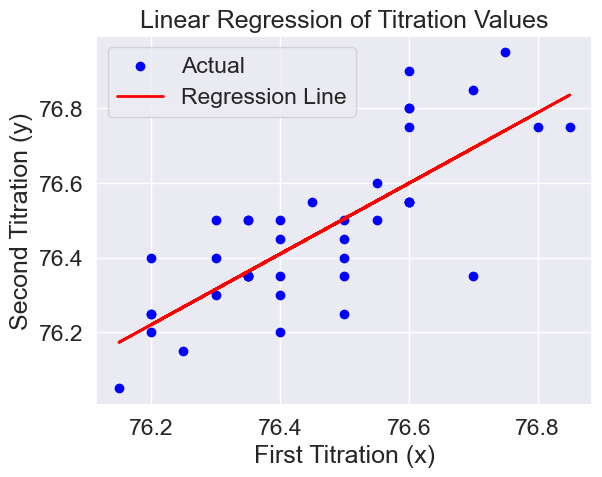

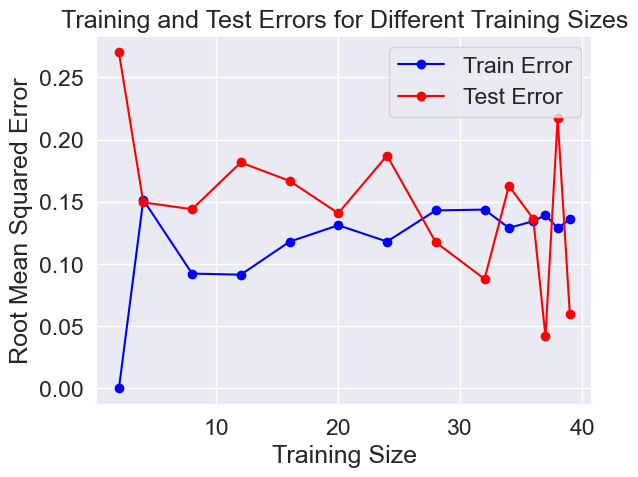

In [2]:
# Load the data
data = pd.read_csv('exercises/data/kalk.txt', sep="\t")

# Split the data into train and test sets
train_size = 30  # 75% of 40 samples
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Extract the first and second titration values
x_train = train_data['tit1'].values.reshape(-1, 1)
y_train = train_data['tit2'].values
x_test = test_data['tit1'].values.reshape(-1, 1)
y_test = test_data['tit2'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(x_train, y_train)

# Make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# Calculate mean squared errors
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Plot the regression line
plt.scatter(data['tit1'], data['tit2'], color='blue', label='Actual')
plt.plot(x_train, y_pred_train, color='red', linewidth=2, label='Regression Line')
plt.xlabel('First Titration (x)')
plt.ylabel('Second Titration (y)')
plt.title('Linear Regression of Titration Values')
plt.legend()
plt.show()

# Evaluate different training sizes
train_sizes = [2, 4, 8, 12, 16, 20, 24, 28, 32, 34, 36, 37, 38, 39]
train_errors = []
test_errors = []

for size in train_sizes:
    train_data = data.sample(size)
    test_data = data.drop(train_data.index)
    
    x_train = train_data['tit1'].values.reshape(-1, 1)
    y_train = train_data['tit2'].values
    x_test = test_data['tit1'].values.reshape(-1, 1)
    y_test = test_data['tit2'].values
    
    model.fit(x_train, y_train)
    
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    train_errors.append(np.sqrt(train_mse))
    test_errors.append(np.sqrt(test_mse))

# Plot training and test errors for different training sizes
plt.plot(train_sizes, train_errors, color='blue', marker='o', label='Train Error')
plt.plot(train_sizes, test_errors, color='red', marker='o', label='Test Error')
plt.xlabel('Training Size')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Errors for Different Training Sizes')
plt.legend()
plt.show()


### Exercise 2 - Building Sheets

In [5]:
# Load data
sheet_data = pd.read_csv("exercises/data/sheets.txt", sep="\t")

# Convert day & machine to factors:
sheet_data['day'] = sheet_data['day'].astype('category')
sheet_data['machine'] = sheet_data['machine'].astype('category')

# Test for interactions
formula = 'log_permeability ~ day * machine'
L = sm.OLS.from_formula(formula, data=sheet_data).fit()

# Display interaction significance
print(sm.stats.anova_lm(L, typ=2))

# Predict on new sheet (from same machines on same days)
# Loop through all data (leave-one-out CV)
loo = LeaveOneOut()
pred_errors = np.zeros(len(sheet_data))

for train_index, test_index in loo.split(sheet_data):
    train_data = sheet_data.iloc[train_index]
    test_data = sheet_data.iloc[test_index]
    
    # Use the additive model
    L = sm.OLS.from_formula('log_permeability ~ day + machine', data=train_data).fit()
    prediction = L.predict(test_data)
    pred_errors[test_index] = test_data['log_permeability'].values - prediction

mse1 = np.mean(pred_errors**2)
print(f'MSE1: {mse1}')

# Predict on a new sheet (from a different/new machine on same days)
pred_errors = np.zeros(sheet_data['machine'].nunique())

for i, machine in enumerate(sheet_data['machine'].unique()):
    train_data = sheet_data[sheet_data['machine'] != machine]
    test_data = sheet_data[sheet_data['machine'] == machine]
    
    # Can't include machine in our model.
    L = sm.OLS.from_formula('log_permeability ~ day', data=train_data).fit()
    prediction = L.predict(test_data)
    pred_errors[i] = np.mean((test_data['log_permeability'] - prediction) ** 2)

mse2 = np.mean(pred_errors)
print(f'MSE2: {mse2}')

# Predict on a new sheet (from same machines on a different day)
pred_errors = np.zeros(sheet_data['day'].nunique())

for i, day in enumerate(sheet_data['day'].unique()):
    train_data = sheet_data[sheet_data['day'] != day]
    test_data = sheet_data[sheet_data['day'] == day]
    
    # Can't include day in our model.
    L = sm.OLS.from_formula('log_permeability ~ machine', data=train_data).fit()
    prediction = L.predict(test_data)
    pred_errors[i] = np.mean((test_data['log_permeability'] - prediction) ** 2)

mse3 = np.mean(pred_errors)
print(f'MSE3: {mse3}')

# Predict on a new sheet (from different machine on a different day)
pred_errors = np.zeros((sheet_data['day'].nunique(), sheet_data['machine'].nunique()))

for i, day in enumerate(sheet_data['day'].unique()):
    for j, machine in enumerate(sheet_data['machine'].unique()):
        train_data = sheet_data[(sheet_data['day'] != day) & (sheet_data['machine'] != machine)]
        test_data = sheet_data[(sheet_data['day'] == day) & (sheet_data['machine'] == machine)]
        
        # Neither day nor machine can be included in the model. Use raw mean.
        prediction = train_data['log_permeability'].mean()
        pred_errors[i, j] = np.mean((test_data['log_permeability'] - prediction) ** 2)
        
        # Alternative: using a model with only an intercept
        L = sm.OLS.from_formula('log_permeability ~ 1', data=train_data).fit()
        prediction = L.predict(test_data)
        pred_errors[i, j] = np.mean((test_data['log_permeability'] - prediction) ** 2)

mse4 = np.mean(pred_errors)
print(f'MSE4: {mse4}')

# Interesting numbers for the manager
print("The manager would be interested in the following MSE values:")
print(f"MSE for predicting on a new sheet from the same machines on the same days: {mse1}")
print(f"MSE for predicting on a new sheet from a different/new machine on the same days: {mse2}")
print(f"MSE for predicting on a new sheet from the same machines on a different day: {mse3}")
print(f"MSE for predicting on a new sheet from different machines on different days: {mse4}")

print("## Same days can't be repeated, so prediction on a new day would be interesting, ## If manager were to invest in a new machine, then prediction on new machine, new day would interesting. ")


               sum_sq    df         F    PR(>F)
day          0.207578   8.0  1.986502  0.065756
machine      0.000579   2.0  0.022171  0.978082
day:machine  0.243994  16.0  1.167500  0.322771
Residual     0.705335  54.0       NaN       NaN
MSE1: 0.015692990204081658
MSE2: 0.015501534979423868
MSE3: 0.015763648019547334
MSE4: 0.014614836001800411
The manager would be interested in the following MSE values:
MSE for predicting on a new sheet from the same machines on the same days: 0.015692990204081658
MSE for predicting on a new sheet from a different/new machine on the same days: 0.015501534979423868
MSE for predicting on a new sheet from the same machines on a different day: 0.015763648019547334
MSE for predicting on a new sheet from different machines on different days: 0.014614836001800411


The results you've provided appear to be from an ANOVA (Analysis of Variance) table. ANOVA is used to determine if there are statistically significant differences between the means of three or more groups. Here’s how to interpret each part of the table:

### Columns Explained:
- **sum_sq**: Sum of squares, a measure of variation. Higher values indicate more variation.
- **df**: Degrees of freedom, indicating the number of independent values that can vary.
- **F**: F-statistic, a ratio of variances that follows an F-distribution. Higher values indicate a larger proportion of variance explained by the factor.
- **PR(>F)**: P-value, the probability that the observed F-statistic would occur if the null hypothesis were true. Smaller values (typically less than 0.05) indicate statistically significant differences.

### Interpreting Each Row:

1. **day**
   - **sum_sq = 0.207578**: This is the variation in the response variable explained by the factor "day".
   - **df = 8**: There are 8 degrees of freedom for the "day" factor.
   - **F = 1.986502**: The F-statistic for "day" is approximately 1.99.
   - **PR(>F) = 0.065756**: The p-value is approximately 0.066.
   
   **Interpretation**: The p-value is greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis at the 5% significance level. This suggests that the factor "day" does not have a statistically significant effect on the response variable.

2. **machine**
   - **sum_sq = 0.000579**: This is the variation in the response variable explained by the factor "machine".
   - **df = 2**: There are 2 degrees of freedom for the "machine" factor.
   - **F = 0.022171**: The F-statistic for "machine" is approximately 0.022.
   - **PR(>F) = 0.978082**: The p-value is approximately 0.978.
   
   **Interpretation**: The p-value is much greater than 0.05, indicating that there is no evidence to reject the null hypothesis. This suggests that the factor "machine" does not have a statistically significant effect on the response variable.

3. **day:machine (Interaction)**
   - **sum_sq = 0.243994**: This is the variation in the response variable explained by the interaction between "day" and "machine".
   - **df = 16**: There are 16 degrees of freedom for the interaction between "day" and "machine".
   - **F = 1.167500**: The F-statistic for the interaction is approximately 1.17.
   - **PR(>F) = 0.322771**: The p-value is approximately 0.323.
   
   **Interpretation**: The p-value is greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis. This suggests that the interaction between "day" and "machine" does not have a statistically significant effect on the response variable.

4. **Residual**
   - **sum_sq = 0.705335**: This is the residual sum of squares, representing the variation in the response variable that is not explained by the factors or their interaction.
   - **df = 54**: There are 54 degrees of freedom for the residual.
   - **F = NaN**: Not applicable for residuals.
   - **PR(>F) = NaN**: Not applicable for residuals.
   
   **Interpretation**: The residual sum of squares is the remaining variation after considering the factors and their interaction. This is used to assess the overall fit of the model.

### Overall Interpretation:

- **None of the factors ("day", "machine", or their interaction) have a statistically significant effect on the response variable at the 5% significance level** since all p-values are greater than 0.05.
- The majority of the variation in the response variable is unexplained by these factors, as indicated by the residual sum of squares (0.705335).

### Conclusion:

Based on this ANOVA table, we conclude that neither the "day" factor, the "machine" factor, nor their interaction significantly affects the response variable. The observed differences in means could be due to random variation rather than any systematic effect of the factors studied.

### ANOVA and Hypotheses

ANOVA (Analysis of Variance) is a statistical method used to compare the means of three or more groups to determine if at least one group mean is statistically different from the others. The key hypotheses in ANOVA are:

- **Null Hypothesis (\( H_0 \))**: All group means are equal. In this context, it means that the factors (day, machine) and their interaction do not have a significant effect on the response variable (log.permeability).
- **Alternative Hypothesis (\( H_A \))**: At least one group mean is different. In this context, it means that at least one factor (day, machine) or their interaction has a significant effect on the response variable.

### ANOVA Table and Interpretation

ANOVA table and its interpretation:

```
               sum_sq    df         F    PR(>F)
day          0.207578   8.0  1.986502  0.065756
machine      0.000579   2.0  0.022171  0.978082
day:machine  0.243994  16.0  1.167500  0.322771
Residual     0.705335  54.0       NaN       NaN
```

### Interpretation of Each Row

1. **day**
   - **sum_sq = 0.207578**: Variation in the response variable explained by the factor "day".
   - **df = 8**: Degrees of freedom for "day".
   - **F = 1.986502**: F-statistic for "day".
   - **PR(>F) = 0.065756**: P-value for "day".

   **Interpretation**: 
   - **At the 5% significance level (\( \alpha = 0.05 \))**: The p-value (0.065756) is greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis. This suggests that the factor "day" does not have a statistically significant effect on the response variable.
   - **At the 10% significance level (\( \alpha = 0.10 \))**: The p-value is less than 0.10, indicating that there is enough evidence to reject the null hypothesis at this level. This suggests that the factor "day" has a statistically significant effect on the response variable at the 10% significance level.

2. **machine**
   - **sum_sq = 0.000579**: Variation in the response variable explained by the factor "machine".
   - **df = 2**: Degrees of freedom for "machine".
   - **F = 0.022171**: F-statistic for "machine".
   - **PR(>F) = 0.978082**: P-value for "machine".

   **Interpretation**: The p-value (0.978082) is much greater than 0.05, indicating that there is no evidence to reject the null hypothesis. This suggests that the factor "machine" does not have a statistically significant effect on the response variable.

3. **day:machine (Interaction)**
   - **sum_sq = 0.243994**: Variation in the response variable explained by the interaction between "day" and "machine".
   - **df = 16**: Degrees of freedom for the interaction.
   - **F = 1.167500**: F-statistic for the interaction.
   - **PR(>F) = 0.322771**: P-value for the interaction.

   **Interpretation**: The p-value (0.322771) is greater than 0.05, indicating that there is not enough evidence to reject the null hypothesis. This suggests that the interaction between "day" and "machine" does not have a statistically significant effect on the response variable.

4. **Residual**
   - **sum_sq = 0.705335**: Variation in the response variable not explained by the factors or their interaction.
   - **df = 54**: Degrees of freedom for the residual.

### Summary

Based on this ANOVA table:

- **At the 5% significance level**: None of the factors ("day", "machine") or their interaction have a statistically significant effect on the response variable, as all p-values are greater than 0.05.
- **At the 10% significance level**: The factor "day" has a statistically significant effect on the response variable, as its p-value (0.065756) is less than 0.10. This suggests that changes in the "day" factor may influence the response variable at this less stringent significance level.

In conclusion, while "machine" and the interaction between "day" and "machine" are not significant at conventional levels, "day" can be considered significant at a 10% significance level, indicating potential effects on the response variable.

## Exercise 3 - Binomial Bootstrapping

Let $x$ be the number of "positives" from some experiment (e.g., classification in supervised learning), where the total number of responses was 100. We will assume that responses are i.i.d., and thus the appropriate statistical model is:
$$
\begin{align*}
x \sim \text{Binom}(100, p),&& p \in (0,1). 
\end{align*}
$$
In the experiment, the observed $x$ had the value 19.


The Binomial distribution is a discrete probability distribution representing the number of successes in a sequence of **independent Bernoulli trials** and it is specified through its **probability mass function (PMF)**:

$$
\begin{align*}
p(x|N, p) &= \text{Bin}(x|N, p)
= {N\choose x} p^{x}(1-x)^{N-x}
\end{align*}
$$

where $N$ is the number of trials, $p \in \left[0, 1\right]$ is the probability of success in each individual trial and $y \in \left\lbrace 0, 1, \dots, N \right\rbrace$ is the total number of successes. The quantity ${N\choose x}$ is a called a binomial coefficient and is pronounced "$N$ choose $x$" and counts the number of ways $x$ items can be chosen from a set of $N$ items. The simplest way to estimate $p$ is through **maximum likelihood estimation (MLE)**, which for this model can be done analytically:

$$\hat{p}_{\text{MLE}} = \arg\max_{p} p(x|N, p) = \frac{x}{N}.$$


We can also compute a classic/frequentist 95%-**confidence interval**:

$$\hat{p}_{\text{MLE}} \pm z_{1-\alpha/2} \sqrt{\frac{\hat{p}_{\text{MLE}}(1-\hat{p}_{\text{MLE}})}{N}}.$$

Remebering:

The term $ z_{1-\alpha/2}$  is the critical value from the standard normal distribution corresponding to the desired confidence level for a two-tailed test. 

- **Confidence Level ($ 1 - \alpha $)**: This is the probability that the true parameter lies within the confidence interval. Common confidence levels are 90%, 95%, and 99%.
- **Significance Level ($\alpha$ )**: This is the probability of rejecting the null hypothesis when it is true. For a two-tailed test, this is split equally in both tails of the distribution.

To find \($ z_{1-\alpha/2} $\), follow these steps:

1. **Determine the Confidence Level**: Let's denote the confidence level as $1 - \alpha$. For example, a 95% confidence level means $\alpha = 0.05$.

2. **Divide $\alpha$ by 2**: Since the test is two-tailed, divide the significance level by 2. For example, if \( $\alpha = 0.05 $\), then \( $\alpha/2 = 0.025$ \).

3. **Find the Corresponding \( z \)-value**: Look up the cumulative probability $ 1 - \alpha/2 $ in the standard normal (Z) distribution table. For a 95% confidence level $ \alpha = 0.05 $:
$$
\begin{align*}
   z_{1-\alpha/2} = z_{1-0.05/2} = z_{0.975}
\end{align*}
$$
The value of $ z_{0.975} $ is approximately 1.96. 

Here's a summary of common confidence levels and their corresponding z-values:

- **90% Confidence Level**:  $z_{0.95} \approx 1.645$
- **95% Confidence Level**: $ z_{0.975} \approx 1.96 $
- **99% Confidence Level**: $ z_{0.995} \approx 2.576 $

In general, the formula for $z_{1-\alpha/2}$ can be written as:
$$
z_{1-\alpha/2} = \text{Quantile of the standard normal distribution at } 1 - \frac{\alpha}{2}
$$



**Estimate p from data. Write down the expression for the estimator**

In [20]:
N = 100
x = 19

# maximum likelihood estimator
p_MLE = x/N

print(f'Data: {x} successes out of {N} trials')
print(f'Maximum likelihood estimator for theta: {p_MLE:3.2f}')

Data: 19 successes out of 100 trials
Maximum likelihood estimator for theta: 0.19


**Find an approximate 95% CI for p when x=19 and n=100**

In [21]:
# 95% confidence interval
z = 1.96
r = z*np.sqrt(p_MLE*(1-p_MLE)/N)
lower = p_MLE - r
upper = p_MLE + r

print(f'Interval: [{lower:3.2f}, {upper:3.2f}]')

Interval: [0.11, 0.27]


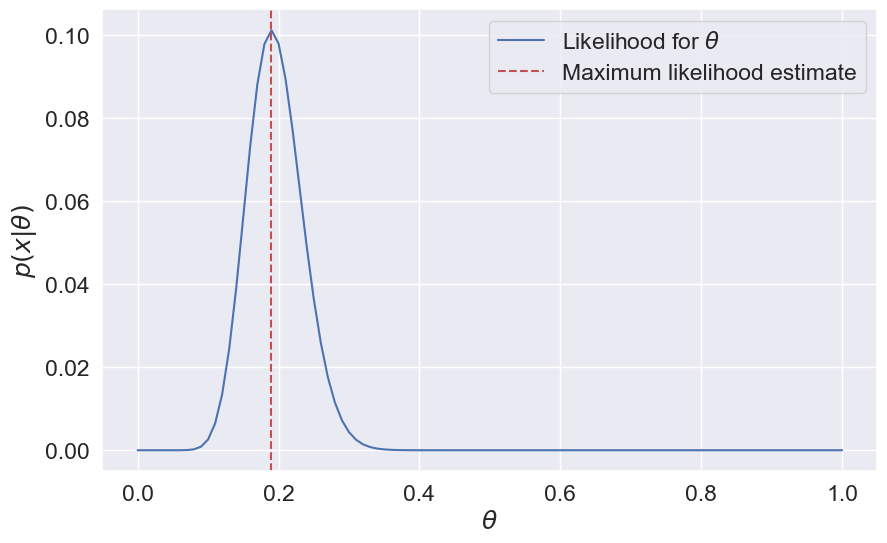

In [22]:
thetas = np.arange(0, 1.01, 0.01)


fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.plot(thetas, binom.pmf(x, n=N, p=thetas), label='Likelihood for $\\theta$')
ax.axvline(p_MLE, color='r', linestyle='--', label='Maximum likelihood estimate')
ax.set(xlabel='$\\theta$', ylabel='$p(x|\\theta)$')
ax.legend();

**Simulate a large number (at least 1000) of data where we use our estimate of p as input. For
each replica, estimate p in the statistical model.**

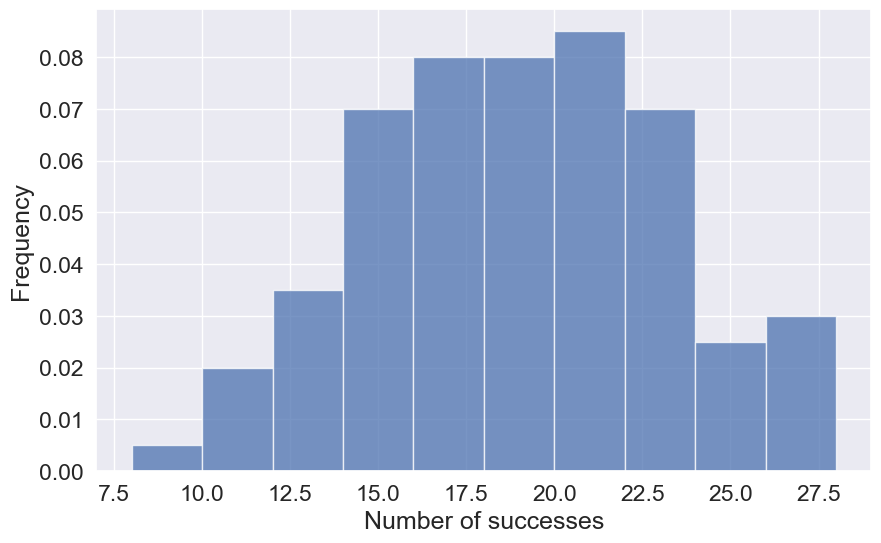

In [23]:
# Generate a sample of 1000 data points using p_MLE          
n, p = 100, 0.19  # number of trials, probability of each trial (before estimated p_MLE)
size = 100 # number of samples

data = np.random.binomial(n=n, p=p_MLE, size=size)

fig, ax = plt.subplots(1,1, figsize=(10, 6))
ax.hist(data, bins=int(np.sqrt(n)), density=True, alpha=0.75, label='Sampled data');
ax.set(xlabel='Number of successes', ylabel='Frequency');
plt.show()

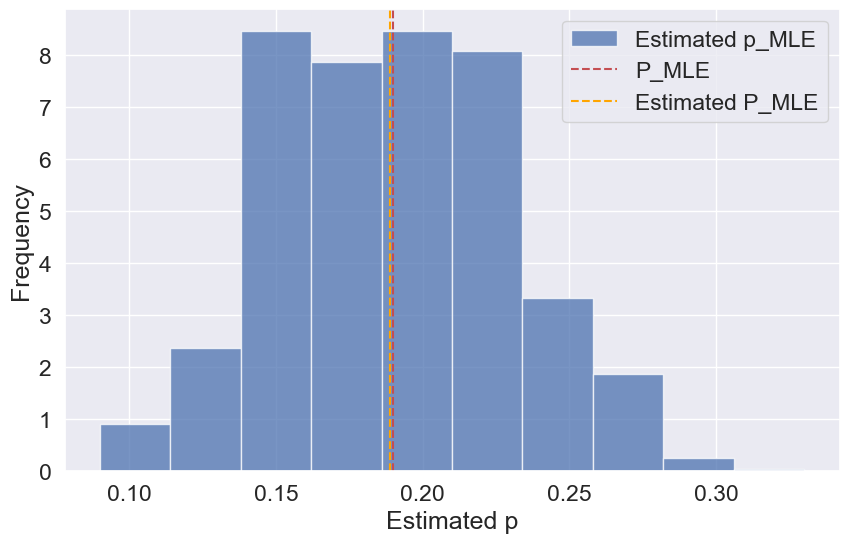

Mean of p_MLE estimates: 0.1887
Standard deviation of p_MLE estimates: 0.0392


In [24]:
# Random seed 
np.random.seed(42)
# Parameters
n = 100  # Number of trials
p = 0.19  # True probability of success (MLE)
size = 1  # Number of data points to generate

# Simulate a large number of datasets using p_MLE
num_simulations = 1000
p_MLE_estimates = []

for _ in range(num_simulations):
    data_simulated = np.random.binomial(n=n, p=p, size=size)
    p_MLE_estimate = np.mean(data_simulated) / n
    p_MLE_estimates.append(p_MLE_estimate)

# Plot the histogram of p_MLE estimates
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(p_MLE_estimates, bins=int(np.sqrt(n)), density=True, alpha=0.75, label='Estimated p_MLE')
ax.axvline(x=p, color='r', linestyle='--', label='P_MLE')
ax.axvline(x=np.mean(p_MLE_estimates), color='orange', linestyle='--', label='Estimated P_MLE')
ax.set(xlabel='Estimated p', ylabel='Frequency')
ax.legend()
plt.show()

# Summary statistics
p_MLE_estimates = np.array(p_MLE_estimates)
mean_estimate = np.mean(p_MLE_estimates)
std_estimate = np.std(p_MLE_estimates)

print(f"Mean of p_MLE estimates: {mean_estimate:.4f}")
print(f"Standard deviation of p_MLE estimates: {std_estimate:.4f}")


In [25]:
# Using simulations find a 95% confidence. bootstrap CI for p
bootstrap_samples = 1000
bootstrap_estimates = np.random.choice(p_MLE_estimates, size=(bootstrap_samples, num_simulations), replace=True)
bootstrap_means = np.mean(bootstrap_estimates, axis=1)
bootstrap_means.sort()

lower_index = int(0.025 * bootstrap_samples)
upper_index = int(0.975 * bootstrap_samples)

lower_bound = bootstrap_means[lower_index]
upper_bound = bootstrap_means[upper_index]

print(f"Bootstrap 95% confidence interval for p: [{lower_bound:.4f}, {upper_bound:.4f}]")

Bootstrap 95% confidence interval for p: [0.1862, 0.1910]


**Repeat the exercise where x = 25; 35; 50; 70; 80; 95. Do you see a pattern?**

Data: 25 successes out of 100 trials
Maximum likelihood estimator for theta: 0.25
Interval: [0.17, 0.33]


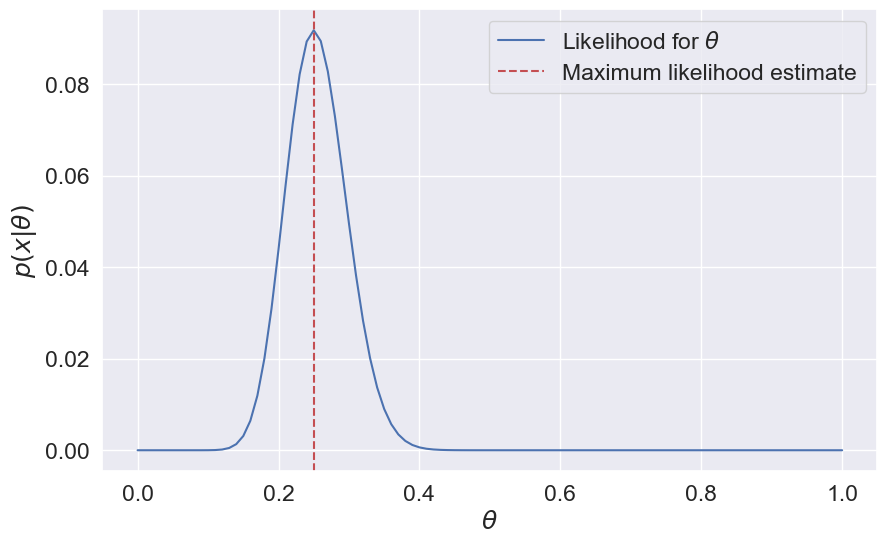

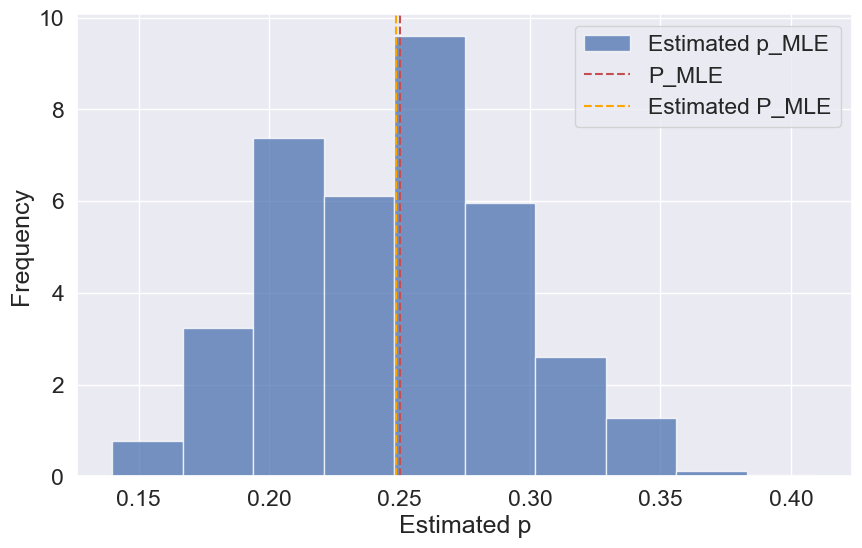

Mean of p_MLE estimates: 0.2486
Standard deviation of p_MLE estimates: 0.0432
Bootstrap 95% confidence interval for p: [0.2459, 0.2511]


In [29]:
np.random.seed(42)
class BinomialEstimator:
    def __init__(self, x, N):
        self.x = x
        self.N = N
        self.p_MLE = self.calculate_p_MLE()
    
    def calculate_p_MLE(self):
        return self.x / self.N

    def confidence_interval(self, confidence_level=0.95):
        z = 1.96  # for 95% confidence
        r = z * np.sqrt(self.p_MLE * (1 - self.p_MLE) / self.N)
        lower = self.p_MLE - r
        upper = self.p_MLE + r
        return lower, upper

    def plot_likelihood(self):
        thetas = np.arange(0, 1.01, 0.01)
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.plot(thetas, binom.pmf(self.x, n=self.N, p=thetas), label='Likelihood for $\\theta$')
        ax.axvline(self.p_MLE, color='r', linestyle='--', label='Maximum likelihood estimate')
        ax.set(xlabel='$\\theta$', ylabel='$p(x|\\theta)$')
        ax.legend()
        plt.show()

    def simulate_datasets(self, num_simulations=1000, seed=42):
        np.random.seed(seed)
        p_MLE_estimates = []
        for _ in range(num_simulations):
            data_simulated = np.random.binomial(n=self.N, p=self.p_MLE, size=1)
            p_MLE_estimate = np.mean(data_simulated) / self.N
            p_MLE_estimates.append(p_MLE_estimate)
        return p_MLE_estimates

    def plot_simulation_histogram(self, p_MLE_estimates):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.hist(p_MLE_estimates, bins=int(np.sqrt(self.N)), density=True, alpha=0.75, label='Estimated p_MLE')
        ax.axvline(x=self.p_MLE, color='r', linestyle='--', label='P_MLE')
        ax.axvline(x=np.mean(p_MLE_estimates), color='orange', linestyle='--', label='Estimated P_MLE')
        ax.set(xlabel='Estimated p', ylabel='Frequency')
        ax.legend()
        plt.show()

    def bootstrap_confidence_interval(self, p_MLE_estimates, bootstrap_samples=1000):
        bootstrap_estimates = np.random.choice(p_MLE_estimates, size=(bootstrap_samples, len(p_MLE_estimates)), replace=True)
        bootstrap_means = np.mean(bootstrap_estimates, axis=1)
        bootstrap_means.sort()

        lower_index = int(0.025 * bootstrap_samples)
        upper_index = int(0.975 * bootstrap_samples)

        lower_bound = bootstrap_means[lower_index]
        upper_bound = bootstrap_means[upper_index]

        return lower_bound, upper_bound

# Example usage
x = 25
N = 100

estimator = BinomialEstimator(x, N)
print(f'Data: {x} successes out of {N} trials')
print(f'Maximum likelihood estimator for theta: {estimator.p_MLE:3.2f}')

lower, upper = estimator.confidence_interval()
print(f'Interval: [{lower:3.2f}, {upper:3.2f}]')

estimator.plot_likelihood()

p_MLE_estimates = estimator.simulate_datasets()
estimator.plot_simulation_histogram(p_MLE_estimates)

mean_estimate = np.mean(p_MLE_estimates)
std_estimate = np.std(p_MLE_estimates)
print(f"Mean of p_MLE estimates: {mean_estimate:.4f}")
print(f"Standard deviation of p_MLE estimates: {std_estimate:.4f}")

lower_bound, upper_bound = estimator.bootstrap_confidence_interval(p_MLE_estimates)
print(f"Bootstrap 95% confidence interval for p: [{lower_bound:.4f}, {upper_bound:.4f}]")